## Graz visualization 2017 SentinelHub-Py

#### Access to the API with the credentials from Sentinel-Hub account

In [1]:
from sentinelhub import SHConfig
# In case you put the credentials into the configuration file you can leave this unchanged
CLIENT_ID = 'ea07da69-1ca0-4d05-9210-844a5bd8282f'
CLIENT_SECRET = 'C:4maj_u_f8_P:QB5da%OOD^U*!Xp0u0{^vzm]W['

In [3]:
config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET
    print("Connection successful")

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("In order to connect to the API, please introduce the crendentials.")

Connection successful


##### Print the config to check that is working properly and the configuration parameters of the account

In [5]:
print(config)

{
  "instance_id": "",
  "sh_client_id": "ea07da69-1ca0-4d05-9210-844a5bd8282f",
  "sh_client_secret": "C:4maj_u_f8_P:QB5da%OOD^U*!Xp0u0{^vzm]W[",
  "sh_base_url": "https://services.sentinel-hub.com",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5,
  "download_timeout_seconds": 120,
  "number_of_download_processes": 1
}


In [8]:
#The next lines are needed for the optimization of the script. 
#``autoreload`` is an IPython extension that reloads modules automatically before executing the line of code typed.
%reload_ext autoreload
%autoreload 2

#The matplotlib magic command 
# With this activated, the output of plotting commands is displayed inline directly below the code cell that produced
%matplotlib inline

#### Import libraries needed

In [201]:
import os
import datetime
from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient, DataCollection, bbox_to_dimensions, DownloadRequest, geo_utils

#For analysis
import pandas as pd
import numpy as np
from scipy import stats

#### Define plot function

In [208]:
#Define plot function from utils file to help plot the results
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

#### a. Download data

In [203]:
#Get the lat/long coordinates

graz_wgs84 = [15.35, 46.96, 15.54, 47.12]
resolution = 10
graz_bbox = BBox(bbox=graz_wgs84, crs=CRS.WGS84)
graz_size = bbox_to_dimensions(graz_bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {graz_size} pixels')

Image shape at 10 m resolution: (1433, 1786) pixels


### b. Visualise the True color image

In [204]:
#In order to download the data, there are some parameters that must be especificed 
#1. data collection: SENTINEL2-L2A
#2. mosaicking_order='leastCC'->> the least cloudy day
#3. time-interval = in our case is June 2019

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2019-06-01', '2019-06-30'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=graz_bbox,
    size=graz_size,
    config=config
)


In [205]:
true_color_graz = request_true_color.get_data()
image_truecolor = true_color_graz[0]

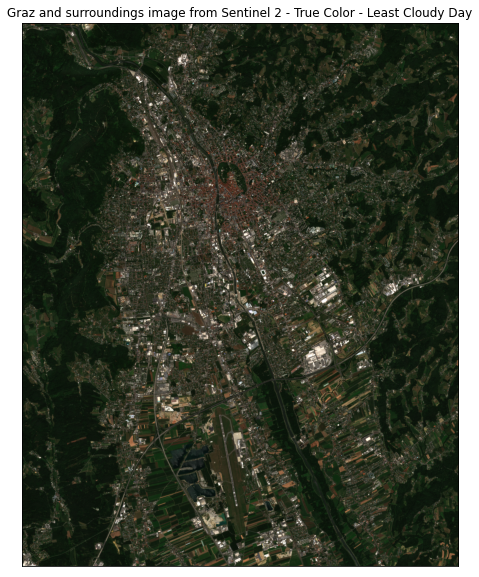

In [213]:
plot_image(image_truecolor,factor=2.5/255, clip_range=(0,1))
plt.title('Graz and surroundings image from Sentinel 2 - True Color - Least Cloudy Day')
print()

----------------------

### c. Visualize "Scene Classification Data"

In [90]:
#Get the lat/long coordinates

graz_wgs84_SCL = [15.35, 46.96, 15.54, 47.12]
resolution_SCL = 20
graz_bbox_SCL = BBox(bbox=graz_wgs84, crs=CRS.WGS84)
graz_size_SCL = bbox_to_dimensions(graz_bbox, resolution=resolution)

print(f'Image shape at {resolution_SCL} m resolution: {graz_size_SCL} pixels')

Image shape at 20 m resolution: (1433, 1786) pixels



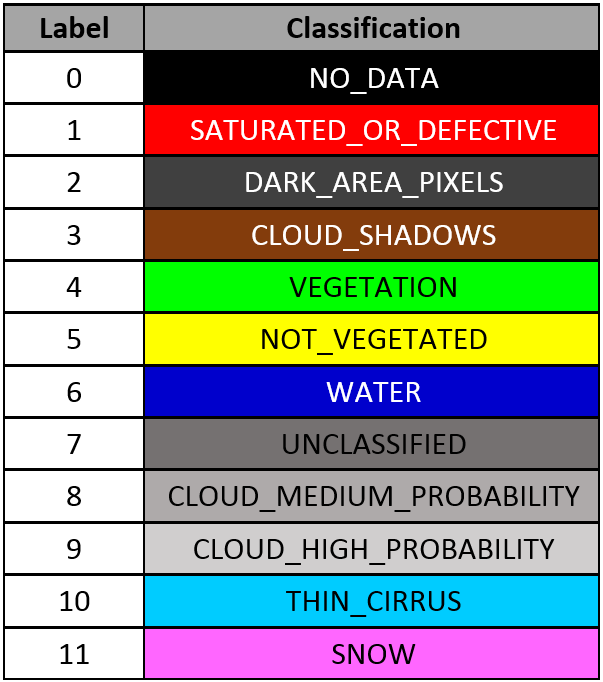

In [144]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAlsAAAKqCAIAAACCaQyaAAAgAElEQVR4nOy9XYgc1533f+5WMEaoL5bxhcIQ9YWDLiw/0GQlZYc1WKiDIasYv/Rj4n0MyvrPNhGjbEAXbhsHKyTjxhDtagJpwTpBCG+bkAiEM7BrFES2CQKjLK1kBbuDOxc7ZsGizEYPO4k2y0P/L34zvz5z3upU1emuOt3fL98LqadeTp069fvUeS0xhiAIgiBoPBZlJwCCIAiCKiEQEYIgCILGY5mIAoIgCIIWTyAiBEEQBAkBIkIQBEEQyUrEd6EKC/cIgiAooEDEiIV7BEEQFFAgYsTCPYIgCAooEDFi4R5BEAQFFIgYsXCPIAiCAgpEjFi4RxAEQQEFIkYs3CMIgqCAAhEjFu4RBEFQQIGIEQv3CIIgKKBAxIiFewRBEBRQ80/EU6dO0bUsLy9funRpGqdYX19fWlqis7z44ovTOIVRc3OPIIdmUICD69y5c0eOHOFkz/KhgKAimn8iPv7442JPb7zxxjRO8cYbb/ApHn/88Wmcwqi5uUeQQzMowFl14cIFegVcWlq6cOGC8ldGuKzUvWavS5cuLS8vz/5FFqqyKkREfpCWlpbW19dDHRZEhKqpS5cunT179vHHH+cGhiNHjpw5c0apCFaQiHKSlAK/vr6u43Bpacm9Vyl68cUXFWZDUIWIOKUnH0SEKiglHCs6c+YMbxkXEeXrOn78+JUrV65cuUIvuLMn4tmzZxnJ+ks2iAjpAhEDCESEMsnYrqiIy2oFiXju3Dlb+6cjtY69piR31q2vr6PVFFIEIgYQiAj568yZMzL5jh8/ztWX9fV1hmWViehQpVJbqcRAUQhEDCAQEfKUXFTE/tZRFtVdGJNxhfVKpbZSiYGiUJREXF9ff/HFF+UhCYQifVSCfthLly6dOnWKdzx+/LjjXOfOnTt+/DhvvLy8fOrUKX17EBHylNxe6llUHM/FhQsXzpw5I2+wtLT0+OOPnz179sqVK/qh3njjDbk8Hzly5NSpU3oH27lz55Q+vzNnzsgHPHfuHJ+O2z/lh1ERncK4l+O8+jijK1eunDt37tSpUzy1g57K48ePnzt3Tj7U8ePHbYlZXl6mbVInTV26dOnMmTPyuSjHjBGDG2D5YvlaKG4Y7whUNdEti4mI3FtulN6FLh/W1n+jPE7vvvvulStX5B0VKa/2ICLkKXepM8r2XDiCvhDiyJEjSgi2FX4aCEq6cuWKDABZx48f583kMSnMEkdiKNnGvUiXLl2ynZcB9q4TukKIU6dOGTNNF23jfmz9hz4pl3/hwgXj2ZeWlmKZTrrIopsVExHdJVXsf4TeTXs2bGe0PZ+ss2fP8sYgIuQjpcnUs9Jgey5SC7ZMCK6fGcWbOYb8yAXbyLbUOqKNiA4MK8lzbEPilwyfOqLjsVX6eo1SoM6/O/JBviNQNUV3KiYinj17dmlp6cyZMxcuXOCYwpN/SXI1UQkcR44cob++8cYb8i7yK7AcPk6dOsVvdvJZ5DdrEBHykdy8IZcftxx1RFoOhn+8cuWK7RTGg9BAHvkNkreR18e5cOHC8ePHU+uI7tQ69pJ/X1pa4r3ovEeOHOEtuU2YH3DqBDE+xe7EvGt/bJUXlxdffJHizKVLlxTQynU+sV/UznzlyhXlJQNtpxUX3aaYiGiTXPJsr9JKU5Ly4sy/c5eA/DSS5KeXH0sQEfKRXHj8y0nW54JLr1w25IM4grL8pHheSHEiyi+mOR78S5cu2XI1HxHlSKL3L8rHlBuKhCT593f33xEM8Km46DbNAxHl500uke7DyuWY/io/YG7x0UBEyEezIaK8Pb+0yZWb5eVlWxemMlTNdrqARJTXuFH6O/zFR1Bq3vmIKGeC3vMnv0bLVVI5Mii7YMhrRKLbFB8R9SFnsuSn1H1Y/fVNaTNxiMMKiAj5SEaCf/R3FGBqJqXmU2MRNb60kZaWluQeAT2FnE5uNjRuVpCIWZ+dS5cu6ePMZXkmxnFq29Fy7wUiRiS6TTERcX19PXXYiz8R9b96ElEeOQYiQj66cOGCI27aZCvASt+5UT7bK/VF48g1ZQh3WURMHVUnQESomOg2xUTEVByKcHVET7yBiJCPlFWwPVcyMxbgS5cupeJQL/BUp9SfIGUzmoen1DuXlpa4plgKEZX3CZs8E+M4te1oufcCESMS3aZoiCgXR5rnm/qUuhud5HJMdb4cHRsgIuQpGTNFZujLpf3IkSO2oWS250hpaFGGaLKUaiV3z0+JiO7hPMrEYrnOKj/Fnol5149tej+iPJpXnk1hS0NqMqBKiW5TlERUHkV5CpGNiMpYU7lw2yYC+5RgEBHylNLuZxzhQtPV+U+pRHRMpXWUXvl10FFo5ZoZP1YBiai8lSq70IJ2+pFtF6L8ST6jntW2x1Y+kT7WVH6nkWv5tjS48wSqmug2RUnEI0eO0BscNfLIJdJGRHkv5f1XXoRCHn69tLR07tw55uj6+jq1O8mv1SAi5KkrV64orZFydYeWJ6RiyWU4lYi8Qtj6+rpS2nn7xx9/nJY6oy2vXLmiHIE2o+E2HOiVGXgMlbCzL+RT8HxEOYX6kbm2euHCBSU/bWd8/PHH5U9TvWt/bJVJWbwk3vr6ujJkVz6XLQ3uPIGqJrpNlSOiUevr61euXPHpPjES0bGj3Efyrl8njW1KL4gIuSUvp+mQu47oOf5LJqLPZo5tptSPmJohPKHCZ1iN2P842Loe9TxUHlufwQrK1dnS4M4TqGqi2xQHEakw2dajkguxkYgvvviicXEm49dE5W+nGSV3IYCIUCbplTlFPl8Mtq24Zmw1dZxObk60bTO9saYk/nSifl5OnmOxN/l3JauNF05/cjy27mWNjSuV68f3yROoaqLbVAkipq4lKDd3KEv4UysKM0wurxw4aBval36hNelty+/SQvvyiejJkZuVSPJLrvH7PlPS7O8RFFBvvPGGMqf2cdP3W7gA60tFKx+LOH78+IULF7g0yttTz4LSp64XfmOS9PmI8lup8iy4U2vb613tQxPLy8t6VlBTKm9Dbbzr6+t8ZH1sDu3CkWF5eZlbXFMfW3r8lcFQtu+K+Cx0ZXz5hiolulOVICKUVbhHEARBAQUiRizcIwiCoIACESMW7hEEQVBAgYgRC/cIgiAooEDEiIV7BEEQFFAgYsTCPYIgCAooEDFi4R5BEAQFFIgYsXCPIAiCAgpEjFi4RxAEQQEFIkYs3CMIgqCAAhEjFu4RBEFQQIGIEQv3CIIgKKBSiAhBEARBCyUQEYIgCIKEABEhCIIgiGQl4hiqsMotNBAEQXOpSYxVom0ZcR7yVbmFBoIgaC41ibFKtC0jzkO+KrfQQBAEzaUmMVaJtmXEechX5RYaCIKgudQkxirRtow4D/mq3EIDQRA0l5rEWCXalhHnIV+VW2ggCILmUpMYq0TbMuI85KtyCw0EQdBcahJjlWhbRpyHfFVuoYEgCJpLTWKsEm3LiPOQr8otNBAEQXOpSYxVom0ZcR7yVbmFBoIgaC41ibFKtC0jzkO+KrfQQBAEzaUmMVaJtmXEechX5RYaCIKgudQkxirRtow4D/mq3EIDQRA0l5rEWCXalhHnIV+VW2ggCILmUpMYq0TbMuI85KtyCw0EQdBcahJjlWhbRpwPrCRJut1uo9Hgq202m/1+v+x0BVBJpQUqWTdv3qQCkCRJq9UybrO6urqzszMej69du2Y7zsrKyrVr17a2tmhL0tbW1o0bN1ZXV4OnVtHW1tbNmzdt6de1trZG6dzZ2VlbWzNuI1+IWzs7O8YjrKysJElC2ziyDppvTWKsEm0zhOdKajgc1mo14zU3m00u+pFqhiUEqpC2tra4DCRJYtxmbW2NNrhx44Zxgxs3brj5YduxSGqN2tra8gHw7du3eZfbt28btylOxI2NjdS8heZekxg7+df+P8So0WhEOKzValwpHA6H/Fra6XTKTWFBlVZeoFKlMGZjY0Pfxk1EpkuSJBsbGwyk1dXVa9euMVds4MmR2q2tLfnH1dXVjY0NvpCdnZ3UyqJMu52dnZWVldxnd+ju3bty3toqo9B8axJjlWgbKHSXo3a7TVcxHA6VP3Ej6mg0KiVtQVROYYHKFkd5auQw4sFBxBs3btCfbt++beTKysrK9vY2bVO85dDNpGvXrtGJ3JDjqhuz3PgekPXsilZXV5WzBHkngKLTJMYq0TZ0DJ+dRqMRXUK73db/urm5SX/tdruzT1solVNYoLLFUZ45oWPPRsSVlRWqbCVJ4iAQd0PaWhdzpNa2gUxo2zZUdUuShKF19+7dIGeXxXheXV3ltw2fHaE50yTGKtF2asF86ur3+3QJm5ub+l+5h6DZbM4+baFUTmGBypYc5TlwK11xNiJy0E+tY/GImIsXL4ZKrU3co2+ENFOQKqzcsOnT+5iJiJQMYq1/RkHzp0mMVaLtFML4jNTpdOgSbMNnqOG0VqvNOGEBVVp5gUqVHOXl5kR5GxsRuesu9Sx8hJs3b4ZKrU1u/MhVNyFdsk+Lrj8RW62WnIaslVFonjSJsUq0DRrAZ6pms+m+hNQNqq9yCgtUtpQoz5CT60w2ItKPnnWmTBt7ptYoN32pU3N7e5v+u7KyQhv7jAX1JyLXibmeyp2pAeeiQFFoEmOVaBs4hM9QICI0r1KiPONEjvtGIjJLPAeM6Ictntqs5+Kqm1wj5IbT1BGq/kSkflO5Rsh1U0xMXDRNYqwSbQOH8BkKRITmVXqUZ0LwbAEjEVMnKSqijcslIlfd5IraxYsX6cfUFl3Ps/MB5WZbfoHg6im0IJrEWCXahozfsxWICM2r9CjPnV4cu+eGiFR1s/2eOhbU8+z0SqHPAPGvjELzpEmMVaLtdCL5LAQiQvMqY5RXJuoZ4cctkFVrNeXamDKMxVh1I/H1uofCZjq7ni08iqfg8CIoLk1irBJtA4bvGQtEhOZVxigvTzQUIUbW2CgVJLWKbKll7OmzMhiW7uT5nJ2xp8OVMwETExdKkxirRNuwEXyW4lYO9+yLer0+44QFVGnlBSpVtijPU903NjZsjPGfeM7IKTiuJNPsC5lJTKNUOZYa8Dk7jyl1q+C8TCgiTWKsEm09S2QF1e126RIGg4H+Vx63ze1IMaqcwgKVLVuU5+820NchqJDYal2pK3bylgXnHvjP0Fc4LS+67ZZjEn3q2bkLNlVY0W1xNImxSrT1LCsV1GAwoEswLufNK9pE/VmocgoLVLYcUV5e143/IW9gnKqhi98UC3YiulNL4gqiklSuutmqgJxIx1jQ1LP7LM3Di4x7Li8Oxa5JjFWibdAAPmvV63UhRK1WU5bzTpKE/1RW2oKozCIDlSd3lOf6FhUSfVgpz+i3VXparRaP5Cw+xtKdWka4ss6qvOi24+Cpk+hTiUjZ5Z7sz9TEim4LokmMVaLtdCL5jMTLeTcaDV7ddDAY8IcvjEueRqRyCgtUttxRnmuBJJ2IPAaHDnLx4kVGUavVkr+bGAQA+b4G5bmqKtcvbWNB3XnlOa/RpzIKzZMmMVaJtgHDdyni1U11Rd1eSppV8YCqpdR6j/wBRePUw5WVFfeHfJMkCfVpwNQvBt+9e1dvjfSpugmPFd3ceeXfV4oV3RZKkxirRFvf2FxhDQaDVqtFnw4WQtTr9Xa7HfVnEVnlFRioTNG0ccesA/kDh4461tra2u3bt+WRlkmS3L17N2zbINf2ZO3s7Gxtbd24ccMIGG4y9VlJwE01d14Rd336Srl1Fw2ni6BJjFWibbjoDYVXuYUGgiBoLjWJsUq0LSPOQ74qt9BAEATNpSYxVom2ZcR5yFflFhoIgqC51CTGKtG2jDgP+arcQgNBEDSXmsRYJdqWEechX5VbaKCFEk/59xS+KQjFq0mMVaJtsOANTUHlFhpooQQiQoujSYxVom2w4A1NQeUWGgiCoLnUJMYq0baMOA/5qtxCA0EQNJeaxFgl2pYR5yFflVtoIAiC5lKTGKtE2zLiPOSrcgsNBEHQXGoSY5VoW0ach3xVbqGBIAiaS01irBJty4jzkK/KLTQQBEFzqUmMVaJtGXEe8lW5hQaCIGguNYmxSrQtI85Dviq30EAQBM2lJjEW0RaCIAhaZIGIEARBECQEiAhBEARBJCsRw/V5QeG1e49gGIbhEAYRIxaICMMwHNAgYsQCEWEYhgMaRIxYICIMw3BAg4gRC0SEYRgOaBAxYoGIMAzDAQ0iRiwQEYZhOKBBxIgFIsIwDAc0iBixQEQYhuGABhEjFogIwzAc0CBixAIRYRiGAxpEjFggIgzDcECDiBELRIRhGA5oEDFigYgwDMMBDSJGLBARhmE4oBeFiEmStNttuqjhcFh2csKoukTc2BjfvTve2dlNaJKM794db2yk7HX37u72d++aN7h2LUPuXLu2b6+dnZSzU2r1U9+8aTj4zo7XFXleV6uV4br4IKurkxx2b0m+eNG82fb2+Pbt8cWL0y0MSbLvjDdvjtfWrLvYkrq1Nb52bbyyEiBVttzjsuo4iy15LC57jiJku03b266NHcV4dXV88+Zk950dNbu4HPqo1bI+Prdvq9ukZhSXrqyFduZeCCL2+/1arbZ3sWIwGJSdojCqIhFXVsZbW9YUK5FCeZ5lra4atslHxBs3OL9cJm1tqb87Lmc8Hm9vpwRon+vKR8S1Nd8tlXywKUlclMrhixf3gdCYQmPuuZO6s5Mei1Odmns7O9bimpqTyo7uIqTcptRUGR86B3R3dnZf3fIRUX98NjZ2f7l5MyWT+Yx8l7MW2pl7zok4HA6bzabYLxBxiuZn4PbtSfRvtcbXro2TxEVEhXY3bnidjh8wRygPQkTl94sXJ2FO36X4dXF6HNv7XHtqPqysjC9enLz1j8e+Fd9Uc9zc2RnfuDGJsCsr442NSVXG+EphTGqrNUnnzk7RmqIt99bWxjdvTuoxt2/75qTDxiKU+74rXlmZZObW1qQ2RneWS6l/kUjdZmVlN3+SJCVhJBlyWQvtzD3PRBwOh3QVtVqt2+12Oh0Qcbrm+pDnwy+bKhPc1up+2DI9YNMgovynsbP5KN91iVkRUT4aY6B4tOK0bW+bq8VCanzTqwWOpPKfHG9XmVJovNjV1Qlm9FtQKSJyNtoy5OJFa1trPiIKv4ZTfiWS37FAxBI1GAyEEJ1OJ0mS8Xjc7XZBxOmai7v/80zmZsONjQy9FJ4P2PSIyM+87XpzX5eYORHlA/pj22afdwUh9ZkpmzmSWuStK1PucU1orLV1V4eIfBX5GhtzE5E7CI11aDI1Fym1eRCxXCVSNwaIOHXnJiLRgt5kmSKOhy3TAzY9IqZeb+7rEmUQUUjv/kUG2vhfKQdWpUfKnVTbncpkn9yzdZhVh4jcSWGriLudm4hibySarfbJTaZKGQARqyMQcermUJgk2bp56Onih4feY1JHh3o+YDOoI9r63nJflyiJiFmx7T6RT8JI29u+SeU6YpEU+ueesa27IkRk6uR+OShCRB7LY3x54kdD+SuIWB2BiLMwN5f5D1zUh2jzw5Y6yqNEIvKIBtsojyLXJUoiorAgKl8ZyL2xI6lciy0YUj1zj5Mn3+KKEDF3k0ymC7Ft43554ibTfNlenkHEiFVFIirzjba2fKchyg8PP2ypvSMljjXlPjDbBRa5LlEeETPxzGjKGc/OSH8itlr7RjLnTl6m3DPWdytCRB7GnLuJuwgRhb3Ngyuv+vQMELE6AhFn5JUVdeZTklixYetvYN64W19nRkSjksQajApel8hCRKN0ZsyMiLac9D+dY8IfzeXInbZMJUekEdEovai75yMq2ztka7zNTZeCRLQhmZtM9XFVWQvtzA0iRqyKEpGLvjzLbTweb20ZMMAPlfJU8+/uQfYlEtE9T7zgdQkQ0aJQ0yVBRM8i4dOnq7R50AuxsZEARKyOQMQSvLq6j4t6lLS1sPHD5u7Qmn2rKU0w54F2NigWvC5RXqspd47mvumZZl56tpr6NFNnsmfucdevfKMr0mpaOhGFqc2DW0eM73xoNa2OQMTS3GqZZ38zHozLQdkmq2V9wKbRj8g9gsYwV/y6RHlEdFyXpzPVMo0Ati2vwx1XxZc2zTqyJkdOKgcJTkQeulXKyBqyPtyafzFOCAERqyMQsUwbJ7O7V0BmOZZPzERE95wtkj7mxRbOHIMei1+XKImITPrUJSsd9l+LwLjQlyOpqUsi+DvT7Av/ySFGT4mImQZqGV2ciPodpCZTWxMIiFgdgYhl2jhS3L0MNMvR/ubzgPkMyePgokciWzizdaIEuS5REhGzLqxjtD+3bBM6c4xvzOpMM/SVBsCKEFHOjXyV5uJEFPuX8+aHwtayDSJWRyBimeYWHg4utvVKjA+bDWY+D5jPnG5+7HUS+KxrKtc+g1yXKIOI7qZgf/P6Z+5I7WgF9VnXtGBvos8qbjmSZ/T0iMgpyVdpDkJE+bWG3z5t9x1ErI5AxKl7a8v6ZOrw4OqIozEzdfnErL1BxjDK3ZwO7LnXrJHhF+S6xMyJKPf1Fv/WEp/L9rUs+YsN+k3xGd9YZA2B1NyTk6ePEKkOERnbtrJNV5ok5nsahIhCalumTHO04oKI1RGIOHXTk09ffWIeyJ+kYXJw90NqXOMwbQysng+YvG7A7duT6LC6Or5xI2XgqDucKas7hrouMSsiTu9rUPLqRRsbk/Kwujre2JjE8RyfW+IadhFy23JvLbavQcmvMrdvTy5H+RrUVImozLNyFCEQsUTx16Ac6vf7ZSczvypHRPnh1CVXpFJXBGW7Vz7zf8BaLVf3nu0lWqSFMyV5oa5LZCGi46Lk7d2z6Mbj8fZ2gNqh8RqN8vkkr/GvPjXsVKfm3s6OtU07NSeVhOUgokN624O7bPMXg7Pms/82cma6u3izFtqZG0QEEYOaputtbU3QuL29r1pG5o9CpI4IcPcCcteXZyjf2Jh8qpAScPduCr2oRmJrCOLaJyUv1HWJvUqkYyK/smCeLiW4MEgUbW2Nb96c1jv76ur45s19U9R3dsZbW+Nr11xZRN1RjtiaaaG4TLlHxdVdJGw5yVLuqbsIGS/NIVtrPJVtRiOX7SL57LmNnGz3KOWshXbmnmcizr2qSEQYhuFoDSJGLBARhmE4oEHEiAUiwjAMBzSIGLFARBiG4YAGESMWiAhP16mDKhWlftBjGs6k4ovdwHNtEDFigYjwdA0iwgtmEDFigYgwDMMBDSJGLBARhmE4oEHEiAUiwjAMBzSIGLFARBiG4YAGESMWiAjDMBzQIGLEAhFhGIYDGkSMWCAiDMNwQIOIEQtEhGEYDugUIkIQBEHQQglEhCAIgiAhQEQIgiAIIlmJGK7PCwovukdPQhAEQSEEIkYsEBGCICigQMSIBSJCEAQFFIgYsUBECIKggAIRIxaICEEQFFAgYsQCESEIggIKRIxYICIEQVBAgYgRC0SEIAgKKBAxYoGIEARBAQUiRiwQEYIgKKBAxIgFIkIQBAUUiBixQEQIgqCAAhEjFogIQRAUUCBixAIRIQiCAgpEjFggIgRBUEDNORGTJOn3+61Wq1ar0RU1Go1ut5skSdlJCyAQMYeuXr1qzMz79+/fu3fv6tWrnsdptVoPHjygfT/44AP3xvfv39fP+ODBg3v37l2+fNm4y2g0Go/Ho9FI/9Pa2hqd+v79+56pTdXly5cfPnw4Ho8fPnxoSxLJloHb29sffPBBq9Uy7mXMAdbDhw8dZ/zggw84x2zHz6df/vKXxvsyGo2MmfDmm2/SNm+++Sb/SPfi4cOHa2trxrNcvnxZLye2bGQphcpRHnRdv359NBrRDeUrun79ulemLLbmmYibm5sMQkW1Wm04HJadwKICEXPoF7/4hTtXHzx44EYC6fr16/Iu7o3dZ7x3756+y/b29ng83t7eVn5vtVpMl4Ax7t69e+70sNwZ+PDhQ5kWLHcOuInIbx5hL/nJvUy2aXt7WwEws00uIQxsG66MyEwthwoRbeVBUavVclxU6qsbNM9EbDabQohms7m5uUm/DAaDRqNBl1av18tNXnGBiDnEkUj+sdVqXb16VaZCauSld3aWG6K0zS9+8Qv5jNevX+dYL/+JZIuAnMhf/vKX6VfrLa5PjMfjhw8fOqpixgx88803OWHG3W2XmSqulpFSkZBJxky+evUqv3MofzIS8UmpBqwXA84u5dqN2Zg1qbq4WN67d48B/Oabb37wwQcPHjwAEVM1z0RstVq9Xk/5MUkSrjgyKSMViJhD7kjEjYdjJ+TW1tZoG8aAu15F2+g8aLVa3Fap/MkYAbk64j5dVnF9ly/H8ULgyED+kx55bTmQKkrSw4cPOdbbGidzyIEZhpxc5bURkX9X2rH5/uqtCNMgIhfLsO8NC6V5JqJNnU6Hrq7b7ZadlkICEXMoNRJxdHO0hTKZuEvP3e5HGxt5wBBSgqweAbnn6f79+2G70wg2Dx484JDq6K9yZKAjIjtywC0iyr179xjbASs6DsxwbstpthHxSalyJifPdnOfnA4ROXk58hkiLSIRu90uiLiw8olEHMhsA22IgoQNpqOjXkUbGOMUp8dNxDfffJNrG2FxyBijUJ5aFXNnIP0pFBGZglRRs9W3csuBGSNdHERcW1vj6j7dIN7Y+HoBIlZTIGLEAhFzyCcScd+VsXGS/0oI9KlX0QbuOqJCIDkC8mga27iVIpLru09KELJVxXzqiHq+OXLAIa680n85r0JlQkAiPinlDHXx0sFtY1CnQUQumcFfmxZHi0jEVquFfsSFlWckom2M0xt4yD4HHe5zstWr6K86D7jmp0c6OQJyvc1nEGxWUeL5SlutFp3LVhVzZKCjkdCWAw5xSngMEbdkhupGdWCG3wzkqr+biE9Kw2K5kNgueUoja3igqeeQaUjRwhFxNBrxBIyy01JUIGIOeUYijiz6n4hhco2Qq1m2ehX9VR9ryu1seqWHIyDH1mnMJ+NahZxyBrCxKmYbayqPcg8sroYAACAASURBVNT30nMgVZyrcjJsA5HyyTHFhbuH5cpWKhF5A5KjgXdKROTGW9L29jamIWbSwhGx3W7PR5PpGETMpYJE5GqKHGi4NmObMu+4idvb20bwUAK4zuGeEZFbjFu5dsvXaJzg4ZhI9/DhQxvzHDlgwwZVXpW/coL911JwSMeMMitGwUkqEZ/cPy3HkUj3fEQdY55EpEtQpgY9ePAAXPTUYhFxMBjQdTUajbLTEkAgYg4VJCLFGp1P7nqV7Q46Ro1yBOQEh51xQbK12TqqYo5Qnjq2yCgjEbnyqiCWf/dcvcUt9wx9/XJ8iCivzuOoE0+PiJxUeX7t2LTgAKRrgYg4Go1oJuJ8LFgzBhFzyZOIPJJF/pHrgjqcuNvJWK+iP3F8XFtb42TYoChHQA7cYWdYG+u7JMdoWz0D5SntNigqOZAqY+WVxBW44vHdSERqqTZ2CacSkTOHmy7zDdm1JTXrRMO1tTWZi5inmKpFIWKSJLxaTb/fLzs5YQQi5lCmkTVKBGHs6ZxgWBrrVfQnhQfcT2bkhDLWlCNswLGmHCt1tDAs9aqYbdEfY8cby3GlRjkWbmVYFn8/yFHxolMbich9eNvb27yl7eCzISKJB3DZUg6xFoKIMg71VWziFYiYQ5lmXygVPvdy1Sydl/S7zgMHRZQIKK8bEKTtixGeKuV0tgzk1wUj9hx/0pW6Cjap+ELnYYmotJzzf429ibMk4pNpdwdizT8RZRy22+2ykxNSIGIOZZqhL1fIeLJdqvxn4zkm/+kRkFMepO1LXqncLaUh1JGBjuV7bDlglNIB5lDBFd0CEpH/xHefC4zxJWbGRMTkfU/NPxF5cOmc4XAMIuZSaiTiCqISfXxGOXLblBIB6UfHuqb66BJjBOR+r+Jxjeu7thon54NSFfNZ11TvTfRPdurA3SelBueCy50HJKKxum9b5vvJmRORq91Y7NutOSfiHONwDCLmkjsSyT0uSo8dhTz3EmK2uYP0o3vNGgW0xggodygW6RByLC4jy7jygM+aNTrMHDmgyDg1XlHqMgKeCkVEG/nk+6VUZ6dBRBqZ7NhdTwakaJ6JON84HIOIuZTva1DuKXosW72KfjRGK9t0AlsE5KDs+ERtqjxn9RmrYu5QbpuF4sgBRamVV+VERSYmBiEiD6gx4pkBr9zfKRGRkvHBBx9w2bh69SrjMOwXxOZSc0vE4XAoPBT1QBsQMYdSv9R6//59fTynbfVRXcZ6Ff1i44FxF0cElGdu+F72fvnUd5+0VMXcody20FpqYaZr96y8Ok6USUGImMpm49cTU8uhcl3uqZO0sdzCoQs49NHcEpFnH4KIkCzbOEaaheZer9IndBob/ShO2bpwjPMCKc7a5qG7FwRwi6njU2PTXwWo4uhYR8241kzqMF1lnXGfNmFPrjvkzmRdXKHnbPdZ550/uilvkzqeViEiV+vdG9OaO9vb24zG+/fv37t3L/gC8fOquSXiIghEhCAICigQMWKBiBAEQQEFIkYsEBGCICigQMSIBSJCEAQFFIgYsUBE6Mm0UYi65m+QReq4TUWYpQ7ZBCJGLBARehJEBBGhcAIRIxaICEEQFFAgYsQCESEIggIKRIxYICIEQVBAgYgRC0SEIAgKKBAxYoGIEARBAQUiRiwQEYIgKKBAxIgFIkIQBAUUiBixQEQIgqCAAhEjFogIQRAUUClEhCAIgqCFEogIQRAEQUKAiBAEQRBEshIxXJ8XFF50j771p4/AMAzDxQ0iRiwQEYZhOKBBxIgFIsIwDAc0iBixQEQYhuGABhEjFogIwzAc0CBixAIRYRiGAxpEjFggIgzDcECDiBELRIRhGA5oEDFigYgwDMMBDSJGLBARhmE4oEHEiAUiwjAMBzSIGLFARBiG4YAGESMWiAjDMBzQIGLEAhFhGIYDGkSMWCAiDMNwQM85EZMk6ff7zWazVqvRFTUajW63myRJ2UkLIBBxGr76tdO/uXPrwf2PKZP/8PudT7c/+tU/9i8/d1Te7CfffJk2+Mk3X/Y/+Ic/7n3y0a9/99tP+SY+uP/xb+7c+oe/uWDb5Vf/2KdkuI/8h9/vjMfjTz76tfI7X4gsvqirXzsdNvfoAikx4/H4d7/99JOPfv3hj3s5Luo3d275XPgnH/2azqVf+zSygorHp9sfyUf45KNf6yVETt4ffr9j/Ou3/vSRy88dpex6cP/jrPf38nNHf/WPfTkxD+5//PG/fOgoTrDb80zE4XDIIFRUq9WGw2HZCSwqEDGsLz93lKKwUX/4/Y4c2f/hby7Q757R559++JYMQl2ffPRrY9D8t8EmbeA+Pm3z6fZHxt8d+s2dW7ZgnTX35NCs6Ff/2M96UXw0xzZXv3ZaPoubagWz4vJzRz/+lw8du//h9zv/9MO3lL24ROl/4oLBR7C9XfHr12/u3JJ/dJSoTC9qMHueidhsNoUQ9Xq93+9TpXA4HLZaLa4slp3AogIRA/ryc0e5DvHp9kccvy4/d/SffviWHp0zEfHDH/do4z/8fuffBpscrS4/d/TDH/f4vA/uf6xH5CBE/LfBpvzjT7758q/+sc/x1HjerOa62sf/8iGTiU80JSJSXZOlXGbArNCLB2/2k2++LL9IKRViLicyzGTL+yq5pF+mXHI4zXL19B/+5sJv7tz6w+93QMR8nnMi9no94+90dbFXE0HEgObXf1tU+qcfviW34PkTkbd8cP9jWyWGz643/U2DiGS50qPvmMlcV/M8TigiEhW4nfZ3v/00NYvyZQUnxlY8fvLNl7mtWKGRO21yW64t9+jscvHjdyz3SwCc1fNMRJu63S5d3WAwKDsthQQihjJDK7UvSt8llYgcTN2v7RwZlc2mR0QleXpvX44M9AzQQYjIbYkf/rjHPHNkcu6s8Cwe3P6pbMa1Z/19iN8kuMLnSPnH//KhnoHoMgxrEDFigYih7IhZNnsSkaO2HM6M5niqNK9Nm4gclN0jOzxzY5ZEJApSzcknn3NnhX/x4NcauemV63P6O4f8J/qH3t3IBUPeHUSckheRiO12G62mMPvyc0cpPzO1HHoSMVPkoi2VcDxtIn4r1wuBYgbS7377qU+XZBAiUmskI5CqWY6xqbmzwr948HXJYGPQ6lVMgvqn2x9xIdS7G7mjUc5Y7ln0b9WAfbxwRBwOh3RpzWaz7LQUFYgYxFnrN8pebtT5dIa5N54BEY1xPKs58b/77aep+C9ORK45cZqZHLbm33xZkal42DamuqNOa6I4bUzb6N2N9LtyZ3nOBv0p+CyahfUCEXE0GnW7XZqPUa/XR6NR2SkqKhAxiPl1OxMPPIloC3NGl0XEfO8Eiq9+7TTHaEqJo2OyOBF5nh//wvVUW7UpX1YYGy2z5iRfr9zNyXVH+pG3kfHGdUd9RI88bWM8HmMaYhDPORG5RigLM/Rh2fm6ZDyJSNt4tsdGTcRv/ekjl587yq2OpN/99lMjSPiifGQ8Ef1J6TU0duMVzIpMxcOWk0xr+XfqO2So8zYy/Lh/0Thi6CfffFlZduDT7Y/AxSJeRCJSk2nsnYhjEDGQQcRQROSjKTPZqZ/MeFE+0k/B1Xol8/l34xyJfFkRhIjf2uv1lG8QvT3INVp9YRrKSXcbw4c/7ilrI9jmPsKpnnMiykqSZHNzk2foz8GyNSBiEE+ViD7z5NhlEZHb32yT7XL46tdOy1xUElaw1dTWFu0eN5svK5iyRVpNvyVNOeWXAyobcp7Lo2fJ1NGYOlCZTi1zEfMU83mBiMjq9Xp0dfV6vey0FBKIGMQcBEsfWWMcfzHLkTXBG9zkeevywYsQkbFnrAnZpnXmzopMFWjHu4UyFMi4Li63kdLZ+Ur9e7jl1ZGCLM63aF5EIo7H43q9ThcY9ZREEDGIU0dkGO1JRJ+Z42TuG1OSYRxwodt2CfS755SDacRQ4+oqRYjoWHtWls7LfFnhmDuhm9Om326l79O41rkyB4Orp5kynIscOhRzeEGJyAu5gYjwt6SpbP5I8CSi/2pbtnncPkNhjQM3yKlnzxTxc9hYxypCRPeC6Sy9TTV3VvgXD9rS1khOV0R/JfTqzaFUx6VWX72j0ceYvF/EC0rERqNBFxh1VyKIGMocRPwbTj2JyPPG3PGUF27WN+Mw7ehMMg7uJ6deF9eKphRAjQ2JuYloW9nHeEXKO0TurPAsHvzuYtuMN+CZKnrfJNcyeZusnbuOeiqc6rkl4mAwaDabxkmHg8EA/YiwbPlLArYBFP/wNxd+99tPOcr4r2vK8dTnuwrGs7uXHuW+OuOIVtrRFqMdK4xn8qfbH9lOwYmXW31zE5ET7GhDZmoq7xC5s0KeDm8rHlzFd3xIRF5qznYVXK7cV2r88pScVM/BXLDieSYiXUK73eaKoDxJXwixuZlhCHgFBSIGtDwGRJ7srHwNKgcRv7V/PZcPf9zjGHf1a6c//HGPYWyrBcqT3z/+lw85DVe/dvrfBptcBzXWCWivaX8NitsD5U/vyvmWY7FWnYjczZa6BCtnl3xdRbKCb/dYmwsvzzZJ/QyT3ORrg5a80IHtSumvtAwCJZi+LMbHL7L80CJ7bok4Go14+IyuWq3W7/fTj1JtgYhh7f4Eq+2LwTYpr/bu8SB/+P2Ou3HMnTa58qo4rRCFGaYvv0/o0ls48xHRsWS2YuOKbgWzwn0Lxn6rqcnFwPYCJK9yYGsc5qzQpRRUOJPnloikfr/fbrdlNNJHE+dgCbcxiDgdf/jj3icf/Zpj3x9+v/PJR7/mN3G2smiZLuOnf35z55Y8aewPv9/5dPsj+YuvPmnj83LaHLsoa5qQfvfbTz/56Nf+5/Ux1VE+3f6Ik/fg/sdyjVa2caSlYn1yHv+Smmxj52uQrFCKB1+mZy/sP/zNBc4fWzWOW33dNU5qIZCLE7VdY43TIp5zIs63QEQYhuGABhEjFogIwzAc0CBixAIRYRiGAxpEjFggIgzDcECDiBELRISn4UyF0D06BobjMogYsUBEeBrOVAhBRHieDCJGLBARhmE4oEHEiAUiwjAMBzSIGLFARBiG4YAGESMWiAjDMBzQIGLEAhFhGIYDGkSMWCAiDMNwQIOIEQtEhGEYDmgQMWKBiDAMwwGdQkQIgiAIWiiBiBAEQRAkBIgIQRAEQSQrEcP1eUHhtXf3YBiG4RAGEeMViAjDMBzSIGK8AhFhGIZDGkSMVyAiDMNwSIOI8QpEhGEYDmkQMV6BiDAMwyENIsYrEBGGYTikQcR4BSLCMAyHNIgYr0BEGIbhkAYR4xWICMMwHNIgYrwCEWEYhkMaRIxXICIMw3BIg4jxCkSEYRgOaRAxXoGIMAzDIQ0ixisQEYZhOKQXiojdblfsqd/vl52cogIRo3R/rwj20rYcCVETQgjRkX5sCJdq9qMlQvSFaAlRl7ZvCtERYug8u02tvS3dm/kkb7B3kJoQA8s2Le+zCOmKWvuTarsjSrY0hOjYUzIWYlO6or59s4bH2eFKWQghFoOIg8FAfmS63W7ZKSqqvbsHR+WRFHbdW/b2ttyUfnTLhpxeGreaQoz27zJwbi+CErEtbdO2bJOPiM29qzMec3M/CI3XmJh27O7fbGQ5vnCeHa6ghRBiMYjYaDSEEPX67hMAIsKluZkWSckNE0V2i2+W0zFv6kL0JFokQmxKf1WqMkxER1XJfYH+JJCZWrNASDdjKV9K+tIZu/uzpS/VxRum9ChEtFEcRIzOC0JEai+t1Wqbm5sgIlyyfRpOuSqpRNusRGxLx7GRJhGipZ1oZkTsSykkOdohZRchIl9dw/5eYntXkE/N2xhzCUSMzotAxNFoVKvVhBC9Xo/bTkFEuDQne7Gybt+Gm0yVUJuJiAybHF1ZMyNiay8rRhlTW4SIXE039qGyG5bN+NScZuPFgojReRGI2Gq1hBDNZnMs9SaCiHCZ5l4xW0RuWJCZiYjUReDfDil7NkRkovT2Z4u7PZmcm4jDvR1trZ1sHkHTsZ+aq4mb2u4gYnSeeyIyAofD4RhEhCtiW6glj+x/9Sei+xSpng0RuSpMCPQfiDsuQMRulksjNeyn5ptle30BESPyfBMxSRIaStPpdOgXEBGuimuWMDqWOKHXIP2JmCnu654NERv7eePTnqxfYNaUND12dG+snJr/q/SAgojReb6JyANqkiShX0BEuCrm1jYdewonZPsTMVPc1z0DInLrpVwjTG1PZucmoq1F2j8blVMn0nxKuYEaRIzOc0zE0Wi3OWNzc5N/BBHhqph5oLRqKl1rih1SQryNiEPL7srp3PMR3T1wnkTs7B1N7jX0b+zNTUThlzxHNuqn5mp9N++J4CqY7irHWCXalhHng6nZbIq9ATUsEBGukHnki/yj0rWm2KGCRFQC9wyIWLNsxvUt9+6VIqJ8N0e5TgRXwXRXOcYq0baMOB9G/f5uH/1oNJJ/BxHhCpkrSfIwRffSX7vF1+Pg/q2mbiJOqdWU64L67EPH6E3ZuYno6MH1zEbjqeWJlY6MhavsuSRikiQ0AVHHHogIV8j6NHz+xTZL3Z+I7snj+jFnTEROnj4zhGHpnpg4m5E1xpWDbKdWViMCEaPzXBJRWcLULZqVEaMyPNVwZa0EXG4ytc0gJPkQkassqR1yxsA9VSLymNJUOWZS5iaiY0yTLZ0tv1NzprXtGQtX2XRXOcYq0baMOB9Aw6Gtq8QgEBEu08py3nUpnhpN8iGibQCk7ZizJCLTOlWOFd1yE5HPnpqNfUsyHKfmsbIDe0cpXFnTXeUYq0TbMuL8dIVWU7halhtO+UXO0X/mGcrJ8vKbjs2EKXBPlYi8OpoN1ZwVji+E5Cai57tCYl/0x3FqeV23rCuew6UbRIxXIOKcmGsV7b3469g4ExETiT2Olb5nTETbIuaKOeW2Fd2KrGvK+xo/baFknV5PdZ+aW2VRR4zOIGK8AhHnxEoTok99zv/bF3JkN34Nqmk57/SIaBxhq5vbk239oAW/BsUXXheiL3F3JERf+m6i8Xa4T53s/74ViBiRQcR4BSLOiZUA6h7ukSq9RpXs/ySvUXXtvKmj0xyzF9xErKftzsl2n6ggEccSm42q2ZdXTT21/AFFEDEi013lGKtE2zLi/HTFg256vV7ZaSmq9HAAx2IOzY5uM3JDpMjWxjgSoidEU6u+dCx1tdH+LXU5kEbtwMa5E9xkmmkCifGienvcchzBkRJOT0eqL9IBm0L0nF2MPqfmxOdbaR0uxfvBN/9EnCeBiDAMwyENIsYrEBGGYTikQcR4BSLCMAyHNIgYr0BEGIbhkAYR4xWICMMwHNIgYrwCEWEYhkMaRIxXICIMw3BIg4jxCkSEYRgOaRAxXoGIMAzDIQ0ixisQEYZhOKRBxHgFIsIwDIc0iBivQEQYhuGQBhHjFYgIwzAc0iBivAIRYRiGQ9pNRAiCIAhaKIGIEARBECQEiAhBEARBJCsRw/V5QeG1d49gGIbhAAYRIxaICMMwHNAgYsQCEWEYhgMaRIxYICIMw3BAg4gRC0SEYRgOaBAxYoGIMAzDAQ0iRiwQEYZhOKBBxIgFIsIwDAc0iBixQEQYhuGABhEjFogIwzAc0CBixAIRYRiGAxpEjFggIgzDcECDiBELRIRhGA5oEDFigYgwDMMBDSJGLBARhmE4oOeZiMPhUNhVq9XKTmBRgYgzcKezW2DqdTEcmrcZjUStJoQQvZ71OEkiej3RbO5uSWo2RbcrRiN1Y2fJVdVqZb6ofn93X0eClUvrdCY/Nhqu9NRqrgNubop2e98RGg3RbovNTfP2nueSc9UtW/KSRNTrKdnSavmeRYhJadncTNlSOZ3xkms10WyKXs9QWuCAJk1irBZtI9ZgMHA+GCAinO5mc1Jm6nXzNlzQul3zBt1uSshWdpw2EUej3X0bjZQte73dLWViuWVDzmAwQY5R9boYDNS9PM9VnIj8liDsNzofEbvdlC0VIqaq0xFJUv6jMZcmTWKsFm0jFhOx7IRMS3tXB0/RMhGFEP2+YRs3Edvt3b/W66Lfn7zjj0ai15uE8nY7JSWOUxS5Lnedg+orCkVypIR5U6uJTmcf+QYD0ens5oOOq9xXTRfYbPpur9BOZ7PRTLuC26Re8nAoer3JK0WjAShOxSBixAIRZ2AOrBSMajVDJHIQkaNhu20OYUkyaSVzt2GGJaJPwylXJRVaZ00Jn6vRcAG42zVUzmZDRPlKjZfsSPNsiDjeKy2cQn/Yw/4GESMWiDgDc2DlsK6HKhsRk2S36lOvu97oua/O3QMXlohJsntAWwvhWGoyVSpMmVLCsHFnQvCrzkREvtLRaPLq47PjjIkoX5qwtFjARQwiRiwQcQaWAyvHSqWiYyMix9nUyMXjd2wDTMahiTiW2gltI4ao8lqw3sZ1Gs92yFBXnYmIdGepR9b/ro1LIqJ/NzCc1SBixAIRZ2A5sHI1UWlSsxGR3+VTz8JHkId0Kg5ORB4DaTwph139r/4p4Zpo7tg9AyLyOCZCIF+4z5ClUog4lt5mMPQ0rEHEiAUizsBKYDUOSLERkeRZTUndODgRx+NJo67+J64q6TVI/5SkjsL1zJapEpEr6Nyoyz27qbwpi4h8TEejApzDC0FEWY1Go91uDwaDslMXQCDiDKwEVi5Tcqg1xn2uHnmO0SiFiNykqWOPqGCs2/mnhAN3vibTIlftT0R6LZBrhPw2kDpfsywiFn/VgB2ZP4mxWrSNWO75iJ1Op+wEFhWIOAPrgZUbrDjKG8NT1phVChG5wVBpGuWWQyMSHFKqmw4iGmcQ6g2V/udKvXFGc9Ox3Gvo39ibiYhG6b2VJBCxFO/dzb0Yq0XbuDUYDEajEf93OBx2u93a3rPY7XZLTFtxpT6KcHHrgVUf1xAvEcdj89BKeeylLSVGFSSiXp79z5V644ym9xt9Uk3qsCPlAn22MQpErJT37uZejNWi7RxqOBwSFGu1WpIkZScnv1IfRbi4jYGVGxspnBnDE1e/qtxqOrYMc6UmU9vQEv+U+Lea2kYh5b5qHyI6WrZ5FJVjrNO4vFZTrtqmtuvCmbyIRByPx529MBB1hyKIOAMbA6s80XAcYmQNh2bH+MYpEVGfhs+/2KYf+KfEMYnTmM8zJiInTx+fwnfEPTGx9JE1uTtoYUfmT2KsFm3nU929AgUiwm7bAiuHpH7fSkT/ud4+r/xTIuJYW6qNm0xtE+r9U+I/c64UIrqXEWc5xnOWPvsCa7mFNYgIIsIu2wIrfyqhVrMS0X9yOm/pGO4/PSIqy3nTdTkaezOlhFHnzoTZE5FpnSpHVpQ7Qz/HIu+wT+ZPYqwWbedT7b0IJI+7iU4g4gzsCKxyk6AxihmnaujmHkf3ZrnZkGq54ZQTE2r1HM4E9+LUsyeizzpBPPzHlvJSiKiPdoZDeRGJyLMyms1m2WkpJBBxBnYHVq4m2qIYB3pbPWM4nCxq6h7WOD0ijqUgS++KYVdY5RqwY6Xv2ROR7p17wCpT09alOnsicmaigjgNzy0RB4NBvV7vdrtyuyjNvqBLq9VqUVcQx2MQcRZ2B1ZlyqsexXgMDh1kc3NS2xgO9303MXUVzakSUf46oIPfuVPCcdz4NSj5g1mhrtp949wr2LG5xmzrB8XXoObM80xEYVej0RgOh2WnsagyPWZwPqdWNeQPKNq+4KN8ZFGR8Uu5unOzwccyuUXaJLxUGSuC3bTPJtdq1sl5Wc+VeuN8Om7J7hXdis9HFJaPbTmEOYjT897d3IuxWrSNWIPBoNPpNKVoVK/XW61Wv98vO2lhlPoowsVNzYmOFir5A4eOHimqCcmDG+t10Wpl+KAP4WR688+4hTB1XGjqEE0bZpJE9Pui1ZrUdeh07bbo982Vntznct84SoDPxBiuPRvvFA1Kcjcyc33UJoWIxkum0tLroWo4XZMmMVaLtlB1tXePYBiG4QAGESMWiAjDMBzQIGLEAhFhGIYDGkSMWCAiDMNwQIOIEQtEhMmZ5LOqHAwvpkHEiAUiwmQQEYaDGESMWCAiDMNwQIOIEQtEhGEYDmgQMWKBiDAMwwENIkYsEBGGYTigQcSIBSLCMAwHNIgYsUBEGIbhgAYRIxaICMMwHNAgYsQCEWEYhgMaRIxYICIMw3BApxARgiAIghZKICIEQRAECQEiQhAEQRDJSsRwfV5QeO3dvjswDMNwCIOI0QpEhGEYDmoQMVqBiDAMw0ENIkYrEBGGYTioQcRoBSLCMAwHNYgYrUBEGIbhoAYRoxWICMMwHNQgYrQCEWEYhoMaRIxWICIMw3BQg4jRCkSEYRgOahAxWoGIMAzDQQ0iRisQEYZhOKhBxGgFIsIwDAc1iBitQEQYhuGgBhGjFYgIwzAc1ItBxM3NzVarVa/X6bpqtVqz2dzc3Cw7XYUEIsKpbrVGVFpu3PhP2zY3bvwnbXPx4n/Ytrl27VPaptUaGTdYWflVkvwPbXPt2qfGbe7e/Z1/8eYT3bz5fz23JG9v/7e+TZL8z+3b/7W29u+l3xG42p53IiZJ0mw2hUVlp66QQEQ41Ssrv6LSsr3937ZtGCF37/7Otg3DbGXlV8YNNjY+4ZKZJP/jPoiPmHNbWw89tyS7N759+79KvylwhT3XREyShOuF7XZ7OBzS76PRqN/vt9vtcpNXUCAi7GMmihFmjMzxeLyz8/9sB9nZ+X9jP2SSPGtjXD1NTf/W1kPP66UDynXilZVfbWx8wlVYR3UZXnjPNRFbrRZdSL/fLzst4QUiwj7mBs+NjU/0v168+B9yoTKSbG3t3+mvtubQ1dV/pQ1u3/4v/odP2mZDRPLKyq+I6w7wwwvv+SXiYDCgq+h0OmWnZSoCEWEfc1eikVLEMHf9ibm1uvqvxlMwdFdX/5UO5UmdWRKRL3bsXYWFF8/zS8R2u01XMRqNyk7LVAQiwp4mShm79+hPN278J/3D2N1IHY223kE+CLWpuqukimdMRD4diAhbPL9EpB7EwUoXygAAIABJREFUZrNZdkKmJRAR9jTXjZRBKNzaubb27zykU+lu5I7Gmzf/r/HgXAclBPIxHZ2O7LLqiLbKLrzwnlMiJkky302mYxAR9jZ3FiodgTxAVN5Gqdvx77Z6lY5SHryaCp5ZErHVGlE/ov+h4MXznBKROxG73e5gMGi3241Gg36p1WqtVmswGJSdxqICEWF/U5lR6m1UZ+IfaRulu5GAl2kYKjec2kbisGc51pSH1dimVMLw/BOxVqsJizD7Al4c8+wI+Ufq/2Nu0TYK/OQ+Qt3GmqXPJEiyPxFt0quhjo23th4Ch7DT805EIUSr1drc3EyShP7U7/cZk1HPygARYX9zvY0bP7n/jyGhL0zDnYK2YTIMUaX3kQHsJtAsibi9/d+25QVgeM/zTkRjPyL/NepxNyAi7G9mGw+QIf7JNULehmuN3NFo7BHkuqA+r4N3tI3HIc+g1XR19V/5LIAinOZ5J2K32zVuwGvZzDhhAQUiwplMA164JZOqcUpzKLWRMn6oo9HW+MnY0xdEZVi6JybObGQNV3+xYA3s9KISkRc7nXHCAgpEhDOZB4VShY9GmiiDX5SBo7SNjSLGNbV1ORYQn+VYU146ANVE2O45JeJ47xJs7aIgIrxo5sXYNjY+4U5EpTmUR8pcvPgfekejbG5iTZVjRbdZEpFrtKkjYOEF9vwSkaZb1Go1/U88WxH9iPBCmep8t2//F7Ui6svQyF2DekejbK5NOqqAdLqx/YsZpaxr6lh8B154zy8Re70eXUWv11P+1Ol06E8YawovlHloKP3DWHsjAiXJ/9A/bDU8x8pwbKambahqWWvWOCgOL7bnl4hJkvAsi16vR7MvRqMR47DRaJSdxkICEeGslr9iOLaAigehkIzw4MZV91BSbne1jc2ZMRE5PT4rzMEL6fkl4ng8Hg6Hthn6zWaTZyhGKhARzmr5a4hjy5wKxgbJ2ODpv0Coe0W34vMRxxrX6cfU0UBY2hQ2ea6JON6rFPJcC1rCLerGUhaICOcwz513LCjD2HA3mfrU27hW6qiPumdocNOrTcqRjWNo2bblW2FYiDvzT8Q5FogIwzAc1CBitAIRYRiGgxpEjFYgIgzDcFCDiNEKRIRhGA5qEDFagYgwDMNBDSJGKxARhmE4qEHEaAUiwjAMBzWIGK1ARBiG4aAGEaMViAjDMBzUIGK0AhFhGIaDGkSMViAiDMNwUIOI0QpEhGEYDmoQMVqBiDAMw0ENIkYrEBGGYTionUSEIAiCoIUSiAhBEARBQoCIEARBEESyEjFcnxcUXnSPLvz1X8MwDMPFDSJGLBARhmE4oEHEiAUiwjAMBzSIGLFARBiG4YAGESMWiAjDMBzQIGLEAhFhGIYDGkSMWCAiDMNwQIOIEQtEhGEYDmgQMWKBiDAMwwENIkYsEBGGYTigQcSIBSLCMAwHNIgYsUBEGIbhgAYRIxaICMMwHNAgYsQCEWEYhgMaRIxYICIMw3BAzy0R+/2+8FCr1So7pfkFIlbfn3vsMSHE5x57zLHNyy+9RLfy9FNPKX96dHmZ/vTZlZVz7bZx92e//GXa5uWXXrKd4pWzZ49//vN8tAMHDnx2ZeX0U08px+SUOA6l+1y7fejQIdsl6P7S009/7rHHDhw4QLscOnToc4899qWnnzYe+fRTT312ZYUf2EeXl584duzFF17wzGfOHKMOHDjgc5Djn/+8O4wo2cX5rJyL8vyVs2dLLJCw23SzJjFWibZlxPkw8iRis9ksO6X5RZdQehmCHaZo/tmVFcc2L77wAt3KP1tdVf4kl9Unjh0z7v5nq6u0gc6JC3/91+fabUdAP3DggIwiTonxUDZ/6emn+YCHDh1ybHmu3Zbxpkih6csvvcSg1aVAyJbPnDm2y/c5iCPNxsS4NxZCHP/8523vN3C5phs0ibFKtC0jzs9CzMt+v192WvKLLqH0MgQ7HJCIQghj9cJBxHPttlzLfPbLX+bfn/3ylznQ6ynJRESqWrEc+/KWTxw7xtfy8ksvnX7qqUOHDslEVOqdzI8XX3jh+Oc/f+DAgaxELHKzfG6ifteUu8mXSX99dHkZUKygF5SIjUZDCFGr1ZIkKTst+QUiVt9BiPjEsWNMNX13BxF5R1tj5rNf/rJcT8pBxFfOnlUSaavL8pY+aOF6p54nmfK5OkQkn2u33XcTLteLSMTBYEBX1+l0yk5LIYGI1XcQIv7Z6iqHUZ1VNiLyYd29mMZd/Il4+qmnaJdXzp6lCpDSFOlzmbrdTcH++Vw1IsoHFEIYe0/hEr2IRGy1WnR1o9Go7LQUEohYfYciIlewHl1eVraxwYObKP2HcuQgIlGQoMt0NAZ6EJHtuJtwuV44Io5GI7q0qEeZkkDE6jsUES9ITaAKb4zwONdu04+ZmuayEpHHplKSONAba6W88aFDh1K70BiunhXcuIh4Idf7CjwDLxwR23uRYjAYlJ2WogIRq++ARDzXbtOMBWU8p5GImSpk+l6eRORRrEw4HshjDPTcWnjo0CH3KfhiKfdSsREdETlhPNwJroIXi4hJktRqNSFEvV4vOy0BBCJW3wGJeEEKo/KWRiJyHStTwM1KRIKWXI3j8xrH8rxy9ixzjrLF0ZGmTCU0TkNMzefKEjHfKws8bS8WEbvdLl1X1JMuWCBi9R2WiDwn4cCBA1wtMxIxaz+ckhKfvZhYMtW4tdbWQ3au3VZmaxw6dMjGxZdfekmZ7f7ZlRVj2vLNR1SGxeabj6jXX0HEeL1YRKzX60KIWq1WdkLCCESsvsMS8YI0LeH45z9Pv5RFRAKbzGb5d+Fc+ObFF17gblFGna1z8UtPP60wia89NZ9BRDiTF4iIPCu/2+2WnZYwAhGr7+BEvLA3vJNjcSlE5LqgPvtQZ7bNr5w9K3MxNZdkMil5El2rKdewfda9g2fmBSIizcoX8U+6YIGI1fc0iMjbE42M8OOAO6WRNYw9vZ+SYWmbmKj45Zde4s5F//MqddPoiJjvlQWetheFiDwrv91ul52WYAIRq28Kpu7VPplDenXBFlu5tvTK2bPG2MpTHfyn51/IQkTjYta6PMf1ZFqhxrhYQXRE5LZlrOVWKS8KEXlW/hxMumCBiNW3T+Dj8Zk6h2yxlYFHn1Mw7q6PwUm1JxF53mGqbCu62c6be/J+XER0T9yES/RCEJFn5TcajbLTElIgYvXNtR/HNAMKuMY2Rkds5aqSrf3NOFXDbU8i8jRERxWQG0J9eJypU43PLo/ciYuI/J6EJtOqeSGIyLPy52PSBQtErL55prn+uQayu8HQ8SeuZ9g64eTPR9h4/OILLxw6dIgT5klEOqy7KZi5xaf+7MqKDRJyIzD9cuDAASNubcsUREREfpVBBbGCnn8iztmsfFkgYhTmCtCBAwdohVL6/eWXXuLgaPs2kDu2KlMLdIzJg1bkGe7K16AyEZEvxz2UlNt1eWIid6nKX82VkyEfkH6hKfyUM+fa7S89/TQzXuFl9YmIr0FF4fknIs/Kn5tJFywQMRZ/6emn5bVaFDmm4rmJKC91ZsOY+7u7ti8G2yTPl0hdWU1Z0U3Gsy6Fr/JXiN1pJs+AiA4p6XFvLDAHscKmGzSJsUq0LSPOB9Z8fArRKP9HHS7d59rt0089JcfWQ4cOuVcmu7DXG+foXWPMHDhwwIGoLz399Ocee4zReODAgc899hhXv9jKKmu6+JNPPhUmvQ+V6nmfXVnhszy6vPzEsWPG9mQaRivnGLW7Gi+Teub0dkgaduQ5D8R2EG4BtkkhonEg7qFDhz732GPy14/hCnr+iTjHAhFhGIYDGkSMWCAiDMNwQIOIEQtEhGEYDmgQMWKBiDAMwwENIkYsEBGGYTigQcSIBSLCMAwHNIgYsUBEGIbhgAYRIxaICMMwHNAgYsQCEWEYhgMaRIxYICIMw3BAg4gRC0SEYRgOaBAxYoGIMAzDAQ0iRiwQEYZhOKBBxIgFIsIwDAd0ChEhCIIgaKEEIkIQBEGQECAiBEEQBJGsRAzX5wWFF92j6z/6EQzDMFzcIGLEAhFhGIYDGkSMWCAiDMNwQIOIEQtEhGEYDmgQMWKBiDAMwwENIkYsEBGGYTigQcSIBSLCMAwHNIgYsUBEGIbhgAYRIxaICMMwHNAgYsQCEWEYhgMaRIxYICIMw3BAg4gRC0SEYRgOaBAxYoGIMAzDAQ0iRiwQEYZhOKBBxIgFIsIwDAf0/BNxMBi02+16vS721Gw2e71ekiRlJ62opkrEb5w//4WTJx9ZWqKz1Ov1L54+/e2LF5XNvnDypBDiCydP+h/5+xsbzz7zzBPHjvEdeWRp6QsnT/7VK69cfecd216Ukr965RXHkf/qlVfogN99+23599dffVWYRBf1+quvBsy3Z595ho//7DPPeGbIo8vLtMujy8tKJnx/Y4PvglFK5he5WNvd9LnL3337bTqRco/k9D+6vKzcGpv/4itf4ZS7b3rWm8J6dHn5CydP6kXakef1ev3ZZ575/sZG6hnp8eHbyvsaT+e+cU8cO+Z+NNjfvniRkv3I0pLjRLnPZXsGfZ7N63uP5yNLS8qOPqK9KD/1Z0S/rm+cP5+vqNDukxirRNsy4nxIdTodWxbX6/XhcFh2AguJLqRgsDA+V/KTrD8zcnEksD1x7JjPka++884XT592l3tbyKYN/uIrX3Ecn8OoEg7k8GrUo8vL7gjib5n0ekqMVvJE2eXbFy+6E6+AqsjF2u6mz13mdCr3SEm/T1H5/sZG1l0y3RRFSpH2yXNHwH391Vcdj48Q4gsnTxoDuvvGPbK0lPoyIRekL54+7dgy37nor/ozaPvddlL+JSsR+Qi2c1HOP7K05PMCYTQdfxJjlWhbRpwPps3NTbqKZrPJ8BsOh61Wi38vN4UFpRSvIP7G+fNcBP/iK1/h1+Hvvv32X3zlK1SC5eLoT8Sr77zDNfUnjh17/dVXudR+9+235bd4Y7jxeepSiaik5/VXX5WDSO73StmUIXyl7sB0XYr+HEZtRPRkdpGLnSoROU9S61iUTs6QUERUjvP6q6/KBTI1z7+/scGPgO12KI8Pc+XqO+984/x5Pl29XtdDtvHGffftt6mCTnu5L1MGjJsK+c5lewZ9nk3bSTOVtKvvvMOVYP3qOPNTU+IwHWESY5VoW0acD6ZGo0G3Vm8gZSiORqNS0hZEqcUrq7/79ttU4Or1ujFsXX3nnS+cPJmPiPyebmtd4bMLrdnT86nLREQ2tzXZwlwmc4Ywftyvq5Q2CqDGNAQhoufFTpWIHLDcjckc9bgNfEpEJDOl5CLnyHP+k96GLLPfRn0uFfrujhvHoHKUAc5ePoXjDS/fuWzPoM+z6T6pz51SDqJfXfEK4vX5JiJdgrEi2O126a+DwWD2CQul1OKV1Qwtz84enxJMdsQR2dwNoG/m89TlI6KcvEeXl4Pk4RPHjvEx3f0rFP2ffeaZ2RDRfbFTJeK3L16k48g9SboZhFffeYf+MVUicpGTk+3Oc668Gs+S+vgYGey+ccZEKiaSPbq8zK0Ojmct37my/u5/Up87ReYXJqX02opfVtNBJjFWibZlxPlgoktwExF1RDaPjEht6MtUguXHVXi0mHG8UF70fIp7biJel17eCw60kTOEBwLYNub3emqRMyY+OBEdFzttIvL1OqovlGlUCGnjqRLRmGx3njP55B/9Hx9GjlJXdty41HDPFKTXr9THLd+5sv7uf1KfO6UfRy5F/LJVpIJ4fb6JyE2jSkUwSZJarSbQj7jf3JOXqeXQk4j+oY2LuxKsfZ66IkTM90LgzhCu7viMZJklEW0XO20iXt+rE9sOpWzsX2z8b4pPsn3qiMqLju32GU1bKn11jhuX+ibBJY0QyNvb2ifyncv2DPo8m+6T+twptl5NDFVBvD7fRBwOh0Q+IUSv16MfR6MR9S/WajWMNdXLYtYDFomVmTb2OUIRIl63xKl82UgZwu1+Rsoyloj9sySi7WJnQER+8TJWX6hyw6miLadKRCMAHHluG76R6fExbuy4cakVIGpZ4Xzjgmdrn8h3Ltsz6Pl0hyLida2aGKqCeH2+iTjeD8V6vd7pdOi/jUYjdhyOQxORx9Rk2sunBGeaJFQiEfO9E7gzxDG+hkdUuhM/JSIaL3YGROT2PX18Df+Jywn9d3pEvPrOO8bhGI6xphxMlBtKTPLsh/Ynojz+0/b4GGeC8l7GTs1857I9gz7Ppu2kOUradamaSIOYPBPgYzrUJMYq0baMOB9YSZJw8ykp9sZSVvHwrReFrNEnU7u/T0yfMyLaLoff4vn3VCIapdc+K07E6/Y3eqo+yr/nK5OpN+X63nQIHiOjACA1z231J8+kuomo65GlJcf4LGO129ZbWeRcxvvr+D1HyfQfuy6/nRiLUz7TMScxVom2ZcT5wOp2u1Qv5MoiZWLUo0xJqcUrR1EAEQtmqZ4hxm4npePHkfj5I6Ktp4re+uUrylcmHRdrlF4fcuS5rZs5U1KzEpEPbgz6tq5Znrqn75LvXPSnihCR6/eeZ/c0HW0SY5VoW0acD6YkSajLUAjR6XSSJBmNRu12mzOx3++XncZCSi1eOYrCNIjI0b/irab8slkkG/UM4cuXxwrJIyrdiZ9Sq6nxYmdDxOumJnp52K1y06dExCeOHbMtyaanWW5RNELROCUgNT0+N+7bFy86Js47uiQcw6fzncv2DPo8m46TZi1peplxrOuW1XTASYxVom0ZcT6YeASNUh2UOxejrin6BD5/87SHTHsFH1nDT7jSdONzhCAjawrGXz1D9PlhfI1yOksZWaNc7MyIyMGae7mo+CmnCHJHPNPvk+eO2euZGhiMryPuG2fr4XN0VDtm9+Y7l+0Z9Hy6gxPR/9T+pgNOYqwSbcuI82HU7/fpEniUqazBYEB/bbVas09bKPk/gT52d8UXKcE+U4bZ3CmiJIN+9Fyt0X/uM5uHJ3guz50pQ5T5YbSN5/D9qc6+UC7WTUR3Bci2IoEx/cr0D3ldG/2mV4eIXJL1Q+mMt5m7kG0L0hr3Mj5EfKhUKbzMca7rIKKImYjcOmr7xgU3qM44YQGVWrwyOd+qgJ4l2H+BJdusdp+hsAyeHI+if0TLkSHyOiDKZGo9kbOcoa9crO1ucsY6bp9t8qUt/fKACEqP3l5NO1aHiI6s8398bN2oqTdOzw0+VKqKn+s6iChipkWz2aRLcBOxXq/POGEBlVq8Mtm9im7BEswPg7vsclTVN+NIZFuGg9OftY3oulRlmV7wZdJz9Le9tk+biI6LtSXeZ60ZHkGq/G5Lv4wQd6itFBH5T0pzhefjY5vvkXrjjDVL2wJP+r32Xw3Adq7rIKKImYi8Tlu329X/yq2m7XZ79mkLpdTildUMJOPa/PSoPPvMM/JzknX+kCOqcog0np0jkS1tjEw9irkfRfcK41ltyxBldJ9jjOhUiei+WMe8PQ73xixy1JBs6ZeLBEl/16HfK0XE69K6pjakOR4fZpj+FLhvnDIn/brUtunuSjB+ciTrueTbASJGqdFoxMNnut0uz8cfjUb9fp//FPU8/dTilcPMlUeXl79x/rzxa1A5iHh9/4h25ePD3754kc/r+A4cdzFS2jjovP7qqzyuwRgdjI/iVL8GpWeI8s0//RqnSsSCX4O6LjX86p8J48O6X2UcLZDC0sdMf6oaEfnFUZ+3x+VQeXy+v7EhT3/0L6V6DvPv/Di4V+Ll1Mp9xlnPJd8OEDFWbW5uynMQFdVqNcy+MNr4wXHWE6YvBtukPPnffftt98dUnzh2zL0UuDtttkExqbOv6vV68dph6iPt/vhcvvmIwj5CJ8fFuuPRN86fd3zi1TZbzkEXbtMTlrDOR57eTTHaTUT3GmnuIuqY/551jmDqOvKO1E5jPqJN/O4FIpavJEl6vR73KQoharVas9ns9Xq2/sWIlFq8cvv7GxvPPvOMTLt6vf7sM8/okdT9/Bvfhb9x/vwXTp6U0Viv15VaY2rauC2I0+ZAKddv9Mf+2Wee8Tyvpwl7xhoPx1lj9Od3eSWTv7+x4f7UuBITi1ysI/Hkq++881evvCIXDOoZdRyWsWfE8BN7H1g27mvrGA54U3Kk+Xra6qz64/PI0tITx4791SuvOLoYbTfu0eXlL5w8qdTpMy1dpvfBZzqXcjt0ossPoy4+GpVw93zfrHfKlqTcpjRPYqwSbcuI85Cv6B6FKgowDMMLbhAxYoGIMAzDAQ0iRiwQEYZhOKBBxIgFIsIwDAc0iBixQMTpOXUwnqKAffswbgpclkHEiAUiTs8IvhU0bgo8bYOIEQtEhGEYDmgQMWKBiDAMwwENIkYsEBGGYTigQcSIBSLCMAwHNIgYsUBEGIbhgAYRIxaICMMwHNAgYsQCEWEYhgMaRIxYICIMw3BAg4gRC0SEYRgO6BQiQhAEQdBCCUSEIAiCICFARAiCIAgiWYkYrs8LCi+6R8N//mcYhmG4uEHEiAUiwjAMBzSIGLFARBiG4YAGESMWiAjDMBzQIGLEAhFhGIYDGkSMWCAiDMNwQIOIEQtEhGEYDmgQMWKBiDAMwwENIkYsEBGGYTigQcSIBSLCMAwHNIgYsUBEGIbhgAYRIxaICMMwHNAgYsQCEWEYhgMaRIxYICIMw3BAg4gRC0SEYRgO6Pkn4mAwaLfb9Xqdrqher7fb7eFwWHa6AigWIv7wBz944fnnP3P4MCX4M4cPN0+ffmt9Xdns9ddeE0IcPHjQ/8g/v3Xr9ddeO3nixMGDB8WeTp448fXz53/6/vu2vZqnTwshmqdPO478o/feo6O9/tpryp+OHj0qNB08ePDkiROvv/aa47xZ7ZMhf/nVrxq38czM712+/MLzz8tXdPTo0Reef/57ly8bt6d81vOE/dP330/dxtPGfKbkGTP5e5cv69tTeXj9tdd+fuvWNMoS5b9eGIwl3GgqjakFMt+5bMWAi/eP3nvPJ3mcNt7RR83Tp3/6/vupV8fXFfDZyW1KySTGKtG2jDgfUu1223a3+v1+2akrKrqQ0suQwz99//2TJ07YbsFnDh+WH8ivnz+f6Yq+fv68HLx0ff38eeOOlKSTJ044Dv7DH/zAdpC0OCD+8qtfTY2/nheYmiGcvVn3/eEPfsDvKLa788Mf/MB47baMdedbVqdmsu2SjTp48KAj+hcsSzYdPXrUXRIYGCQ3EnKcy1YM+Dbpt9h4Un5YshJRTrbxXJwD7udxZqbETGKsEm3LiPPB1Ol0dm9Ms8mVws3NzVqttltKIq8pGst6dfyj997jKPPC889zPPrp+++/tb5O4Vh+DDIR8YXnn6eNP3P48Fvr6xxKfvr++6+/9pp8Xn3fIERUfv/Re++9/tprzJjUUOjj6RHxrfV1+uvBgwf/8qtflUPVD3/wg7/86lcpA/W6hS1PfPItq/Xj/PzWrbfW1/nmKqcwXvKP3nuPi8rBgweNNyV4Wfre5ctcwdXJLZvqcCx3puU4V3Aiet4p47mMB+HMT03JbEyJmcRYJdqWEefDaDQa0SU0Gg3lT8PhkP7UarVKSVsopYbLEv3zW7foQT148KCtrH/9/Pl8ROQtX3j+eWOM47MLU/PdNIjI5+UnvPg775SIyDg8evSoo1Ly9fPnP3P4sP+1p+ZbVtuOww2zCrAdl8x/0gvDlMrSz2/d4tcjxzXSNs3Tp+mK9AwveK4qEHEolVKlvFWtgjicYyL2ej26hM3NTf2vrVaL/pokyezTFkpVJqIjBqXu4t7s57ducfhw1MNscXM4TSLKxxdCePYkFcmQrETkGOTOPZurQMSh1PMkB3RHdtki71TLkjGRsrkF8q31dX6RcjTt5jhXRYjIp1Pq2Zy8ilQQh3NMRDfz3LyMRVUmos87r2JPInJDUypvOEwo40SmTUSOv0ePHi2Sh9MgYsFGqooQ0RhJ3dllJOJUy1JquKd7QZRlOhrbZnOfqyJEHJqqifw6Up0K4nCOidhsNh2XMBgM6K/dbnfGCQuoyhKRR/1lCoueRLQxQDc/9kr/yrSJOJQGEBYZPheciD+/dYt+zI3q1GuvJhH5HUXhzVTLEr982MoA8YCTRC2fjuHBOc5VHSLq1cQKVhCHc0xEHmU6GAz0v4KIU3W+su5JRNrG873SuPEMiMjXYpvGECpDMhGxOK5Sd58NEY0AcGSXrWY8vbKUWgHit0YuIVwNtVVYc5yrOkQc7q8mVrOCOJxjIvb7fbqEdrut/xVEnKq5hpSpp8oHAFzLcTQu6eV79kQMAobgRCz+Vl4FInIDo3IHbWNNuTQqZWZ6ZYnHfzqmfFCq5BohX5dt6l6Oc1WKiHI9m4d3VaqCOJxjIiZJwrMsut3uaDSi34fDYafTkf9UbjqLqLJE9G+Mku0DgKwBdz6I6COfzHQQ0TgbTw/N/umZBhF/+v77PHFQB4Ajuw4ePKinJ2BZMso4oZNsgzEPajW+SuY4V6WIyEc7ePCgPvmqIqZrmcRYJdqWEeeDSZ56qAhEnKpBxPkgon5Y//RMdYa+uz6ky9gOOW0ikozzEXlEj3Ij+HfjCO0c56oaEZUJ/lWrIA7nm4jj8Xg0GnU6nUajwfeg2Wz2ej2ekggiTsPTI6LPkDy9fM+eiNxLVGQxsxJbTW2HTb32qa5Zw0vlGatQ+iXLs9d1KE6vLP381i33xHn6kz4S2z1KOce5qkbEodSnm7pqXSmmtE1irBJty4jzsxD3I0a9lltquCzLqTOxjA4+sobbppRnb5Yja4q8BQcnInfe+A+CyHrtsxlZ459dPHvduGDNVMuSPHFeHgHE2DNWH5lteiU4x7kqSET/U5fiBSUiz0fk/sUYVVkiuht/bPYkYuogdbatokYPuXuuJD+3+iX4PP/5xhblyJBMRPSfKDk3RBw63wNClSUbMPjU8l7GBbt16bzMcS4QMaspbZMYq0TbMuL8LETtqPV6veyEFFJquCzL+RZn8iSi/xxz2yQtH1z5PngxAAARD0lEQVTZenqGHs+/z3r/oTIk6wx93t6de/NExKGdfMXLkhsYxtxwL7DO0t/YcpwLRMxqStskxirRtow4P3XNx9SLcYWJOPSOvLI9ieheOJhtG6M/lN6mHSuV8KA42zPjeP6ZuAWf+WkQkXPPvRb5nBGR/6Tc8eJlyQ0MvWbJvzhWAOfyk2mtJWMtFkTM6oUj4nA4pIGm9Xo96kVNx9UmIgcRx5Qs+lgE/9eTiEMpXtvGRPBnN4xn59nBtrS5+9vcz3/AgQPTIKKcQsdK33NGREdzccGy5AaGvnRZ6kI2Q4ltxhV2/M/lyBMQ0X0tkxirRNsy4nwwtVqtfr/Pn3wajUbdbpdwWKvVYv8U1LjaRBzu/+TQ18+fN34NSq6E+RORkUbP6vcuX+bqzo/ee+/r0rfubLVADjqUNg4i8seDbLUo4/Mf19eg5A8k6V+Dkr+O5HPtsqtJxKFU8VKoVrAs2YDxvcuX+dZwddB/FT0+qVyKMp3LnScgovtaJjFWibZlxPlgEhbV6/U5wOG48kQc/vM/y1+z02X7YrBtY/nIP791yz09yzE/2idtJ0+csCHNcVJScRgoGeLYJh8Rhx7fyD148KDOgNQLrCwRbRWvgmUp0xxBn+Z6snFFt2nMR7SJ3xFBxH3Rtow4H0z9fr/ZbPJk/FqtRrXGstMVTMayXjX//Nat11977eSJExx/P3P48AvPP68v+Mkxyyjj0FCq0PCAddqsefq052eYOG3y7i88/7z7WZVPp5zXNlUun2l0j3skpPz9hKz70gd4m6dPy2M9jh49+sLzz7+1vm68ELqJjiHE3MZYZCKm57myXrJtFuCwQFmyDRylbFQKEt+s1EJiXJo807ncecLft7KJiUh1a3cXQKY7xf0pju9elWhK2yTGKtG2jDgP+YruUellCIZheD4MIkYsEBGGYTigQcSIBSLCMAwHNIgYsUBEGIbhgAYRIxaIGIsdQxh0+SwqFpFTR0gqquaAC3hBDCJGLBAxFoOIICIchUHEiAUiwjAMBzSIGLFARBiG4YAGESMWiAjDMBzQIGLEAhFhGIYDGkSMWCAiDMNwQIOIEQtEhGEYDmgQMWKBiDAMwwENIkYsEBGGYTigU4gIQRAEQQslEBGCIAiChAARIQiCIIhkJWK4Pi8ovHbv3p0xDMMwHMAgYrwCEWEYhkMaRIxXICIMw3BIg4jxCkSEYRgOaRAxXoGIMAzDIQ0ixisQEYZhOKRBxHgFIsIwDIc0iBivQEQYhuGQBhHjFYgIwzAc0iBivAIRYRiGQxpEjFcgIgzDcEiDiPEKRIRhGA5pEDFegYgwDMMhDSLGKxARhmE4pEHEeAUiwjAMh/ScETFJkna7TYkfDofujfv9frPZFHtqNBrdbjdJktkktbhAxJh8sCY8dbA22et0SwghTrdcRz7aMG9j2/dsZ/dEh+vi74fmY94Y7Sa40wuWAz9LRKcnTkyeOHGiKc52xI1R5pQr2XW6Jb7TT7kQRUcb5lPLN8t97Z3e7qGMefidvjjdmpz6cN2VSLg63g++uInY7/drtUnpHwwGti2TJGk0GsZwVK/XU1FaEe2muPQyBPs4HxGJHyeariOT9G1s+8pMOlw3H/PvBrsbrHXDXH6n58qBs53MKdd1tCF+llgvxCYjpXyufa27u9nfDfb9/rPElc6AbxjwNCyEmAMiDodDubZHchCRcciVwtFo1O3uFvFGozHDtOfX7nWWXobgfPah3bSJaENCWCI+t9tsIw7XxXf6E2793WDyJ5kr7pQrv//t5uSK9F34QuTj3xiJte6E0ArS7hQjIlVwhRDPtSd10L8fik5PHK6DiFX3HBBxOBxSamu1Wrfb7XQ6biL2+33aoNfrKX/iffv9/vQTXlQgYtwul4gnmuJwXQghDtZcVaviRPxOf0II/UR3xuLvh+JoIz8R5T8JrQ3TSETlT3rzbG4i3hhZbwccheeAiIPBQAjR6XSotsdVPRsR6/W6EKJer+t/SpKE9m02m9NNdAiBiHG7dCIyq/TQH4qIP0t2q2KH62YcZrpqR27YrsVBxDvj3XcC/SHKTcTgrc3wjD0HRByPx/JwGDcRR6Pdl7hOp2M8FDeoTiut4QQixu3SiXhnPKkmKmNMQkV2Hn6SaVBJDiLaEuwmItcsjVkKIi6g54OIstxE3NzcpL9ubm4ad+eG0+qPrwER43YViCg3acrbhIrsRxt5SmmROqKCXp86oj68KDcR/363BydbnRiujheNiKltqqkbVEcgYtyuAhHvSPUkuZoYioi2tOXLGdvvP0t20av3iTqI6Gg0zk1EOT8P180YhqtsEDHrBtURiBi3K0JEZoa8ZRAicoVJmVyRO2dsY025Jqq3zTrGmpKMczaKEFGZAUn9tWFLDjw9g4hZN6iOQMS47U9EH+Um4h1pwgAH9yBEzH2QHPMRD9fF32660mCUbfirT7JtRLwzFj9LJlnKyQMXo7AQAkTMtEF1tPuwlV6G4HyuDhF5zsDRxu4vcRHxYM26+I6DiErXqWyfZDuIyKfm2ZZ8j9C5WHELIUDETBtUR7uPWellCM7nirSakjl2U1WmykTk33+WiO/0d5sobVDUW03/frhvEr0jSwsSkXxjtI+LmKdYcYOIWTeojkDEuF0pIsoTB+8EIuLPkpwYyJRy7q10z8qwrSxj5FlAInIiHUvkwNXxohGx19udIJU6+2I0Gk05pUUFIsbtShHxjhTiv9MPNtaUK3BBcsb2u3EpOLKNiO7FZUiOZlU5u2wNtoodQ1vh6njRiEgL3Aghut2ucXeaoV+r1aaczAACEeN21Yj4s2QyYT8UER2synHVtt8Zb/p6bI7ZF5w2HWkEcu5VNZprmZ4Xhcn7UXjRiDjeuzTjct68ok273Z5yMgMIRIzbVSPinf31mCDh2zi1I3fOOFJunFV5x29dU70uyLC0fS6KG5ndH+qS/be7a4Ngse9KewGJyB9Q1BtOW63d977qL1gzBhFjdwWJeEda1y0IEe+M04ex3BiJE819nCjCcmXuo+e6prZ5/cbZinfsdd8TTWuO2ZgNV8oLSMTRaESfUazVav1+n78GxTi0LXlaNYGIcbuaRFSmKxQnIi8oQyf9203z16AKEvGOpc/STURedlWvt8nfVZa/YCV/fEpnPP2JvvrE5JN3ybpYATxjzwER+WtQDilfd1K+LSwrivZS0m6KSy9DcD5Xk4h3pNpMECLeSfuIrs6JfClnhslz4d1E5NGwxi8n8wF90kyWx5R67gJXykKIBSTieDwejUbtdpu+DCWEqNVqrVar+jMuZO1eW+llCM5nak50d0T5bENNf/o2tn1TjynX6owLweQz1Qj5yELsNpbqrYj5Us7Lp8lVN56bYRsRytgzNmbeGImznX1pPtoQZzuulk+aJXmiOUHj0YZ4ru07JBUu13NAxIUViAjDMBzSIGK8AhFhGIZDGkSMVyAiDMNwSIOI8QpEhGEYDmkQMV6BiPDs7B4sqgsDSeAYDSLGKxARnp1BRHgRDCLGKxARhmE4pEHEeAUiwjAMhzSIGK9ARBiG4ZAGEeMViAjDMBzSIGK8AhFhGIZDGkSMVyAiDMNwSIOI8QpEhGEYDmkQMV6BiDAMwyENIsYrEBGGYTik3USEIAiCoIUSiAhBEARBQoCIEARBEESyEjFcnxcUXrv36P8bwzAMw8UNIkYsEBGGYTigQcSIBSLCMAwHNIgYsUBEGIbhgAYRIxaICMMwHNAgYsQCEWEYhgMaRIxYICIMw3BAg4gRC0SEYRgOaBAxYoGIMAzDAQ0iRiwQEYZhOKBBxIgFIsIwDAc0iBixQEQYhuGABhEjFogIwzAc0CBixAIRYRiGAxpEjFggIgzDcEDPGxGTJGm325T44XDos0u3263VakKIXq837eSFFYgIF/Hgzwfto+36wToVpNof1ZqHm73VXvJ/EnmzzS9u8gb9p/q2ozX+uCGEaNVbjjP2n+q36i0+oxCi8ceNzv/qDP58oG88fHZI23T/pGs7YPdPurTN5hc3bdv0Vnu7AeHZYel5Dlfcc0XEfr9PbCMNBgP39oPBoNFo8Pbdbnc26QwlEBHO7c7/6giLFKoxdUij/z0yHpD+2jzcNP5184ubMgiNJ1VInPyfhKlpuwrCsJvErXqLtlGOD8O654SIw+Gw2Wwqz5iDiHJVEkSEF81cbWr8cYNrTqP/Peo/1W8ebrqJ2D7aNh7TQcT+U336a+2Pat0/6fIZk/+T9J/qM9Uaf9xQoNU83HTAjJFJR7ZdbO2Pam5kwjB7Hog4HO62rtRqtW632+l0UonIVcl2u93v90FEeKFM1bXaH9V8qk1MxPbR3ZdIYyOnjYiDPx8w8Gz1Sz6ywi0mt7G1lptzHanis/dWe6VnO1x9zwMRB4OBEKLT6SRJMh6Pu91uKhGFEM1mczQa8e4gIrw4dtTndP//7Z2xcRsxEEWZKeMMc2WXOVOkAhRQkRIHVKTQM2yBHbCSq4AVsAE1wA7YAxys5msN7IFH+TwyeO/PC2gSR509Hr1ZLICTEU+vp8qFQx+pzqu38VQp+mFqJYaFqXlUk7Fhu9Hf/Lf/s8P/zy0YMaVkLrSMMaIfjxFhbnzNiMkVc+VKlvA760rzqODbPez8+ya8btmVl9hH+8e9vQjbjSba8HKAkhsxos8YI/pgRJgb1lq7WLcZ3ogqE0vHhEbUteGUZvgNmdjk4OxWdSfHl6NWCQ2tzcksCzAERsSIMDskqtXd6mKDzRvR/zHr7YVG1JTpmLsKB6t2zO5Tq3X8mOyW9P4YHwMkjJgwIswS9e2s4Cu3IYrMiOe3s5WY2cKc0IhXTVoO6dPezBbdWO2oN21MNjdrtWNlGSpABkbEiDBTsm0VtjWi9GJmxOSWgPrFLKERwzeHGDKiNhT6N613qMLRxmTyszHsu4DxYESMCPPl9HraPezUVrR6LuvYlUZMbv+G1nD+OyNKwJr81IId3Wp5MI0ajZVzdgAyMCJGhLlzfjvvH/fyYjYdGhpRbTxNVIbys+/8y1lTuU0LZMx/viLUGFWNukP2XcB4MCJGBEjpVzq/ndVc9NOhoRGTE5gpJzTiVStr7KeHbT/7SMtQbY40mw61slU3YI3GyglwACUYESMCfBDuwR8yoo6DsTIxNOLQ3okS7ZQI237aX2H2tdIzW32a7cGwMZVTwgFKMCJGBPhkvBGTW/NyfDmagTIjauryopk0Mmz7yb79U68mYjYdqr0Wh+dD2WgEGANGxIgAH4SFWsWIvqa0CdLMiENbNcqfe/GoVfue7Y+tNRHL3qRuXmPYdwHXghExIsyL/eO+fPSSPioLtYoRk5sXDWtEf3n5aAvD9y8r60K1v8JehMfCmZW7ZWcvLh4dB5CBETEizAtT1OputXvYaVLx/ee73JatRqkbUVWgisVyjNbXdMuuf+o122nPn9JR3XWBaVq14k7twbBUHiMMEHILRtTToCrp+95f4h8sHGa73X7XX2d8MCJ8AV+TlVnfr7NKrm7E9OdO/6Gth5UHFC/GHSbnn4a4GNhTofahhUcEw7V8/FfX79j8t20LwYgA13J4Pmy6jeqzbtltuk1YVI3pyam+rJypbacBqF6071zfrysHyGVoIU9lT4Vkz5QpfIFbMOJsgxEBACYEIzYcjAgAMCEYseFgRACACcGIDQcjAgBMCEZsOBgRAGBCMGLDwYgAABOCERsORgQAmBCM2HAwIgDAhGDEhoMRAQAmBCM2HIwIADAhGLHhYEQAgAnBiA0HIwIATAhGbDgYEQBgQjBiw8GIAAATcsGIhBBCyKyCEQkhhJDFIjQiIYQQMudgREIIISSllH4DLgfIWnUqe0QAAAAASUVORK5CYIIA")

In [243]:
#The parameters in this case are different
#bands: SCL
#output: medatada SCL
#return: sample.SCL

evalscript_SCL = """
//VERSION=3

 function ChangeRGB (r, g, b){
 return [r/255, g/255, b/255];
}

function setup() {
   return {
    input: ["SCL"],
    output: { bands: 3 }
  };
}

function evaluatePixel(samples) {
    var SCL= samples.SCL;
    switch (SCL) {
    case 0: return ChangeRGB (0, 0, 0);    // No Data/Missing (Missing data) (black)   
    case 1: return ChangeRGB (255, 0, 0); // Saturated or defective pixel (red)   
    case 2: return ChangeRGB (47,  47,  47);  // Shadows (very dark grey)
    case 3: return ChangeRGB (100, 50, 0); // Cloud shadows (brown)        
    case 4: return ChangeRGB (0, 160, 0); // Vegetation (green)
    case 5: return ChangeRGB (255, 230, 90);   // Not-vegetated (yellow)
    case 6: return ChangeRGB (0, 0, 255);    // Water (blue)
    case 7: return ChangeRGB (128, 128, 128); // Unclassified (medium dark grey)
    case 8: return ChangeRGB (192, 192, 192); // Cloud medium probability (grey)
    case 9: return ChangeRGB (255, 255, 255); // Cloud high probability (white)
    case 10: return ChangeRGB (100, 200, 255); // Thin cirrus (blue) 
    case 11: return ChangeRGB (255, 150, 255);// Snow or ice (pink)

    default : return ChangeRGB (0, 0, 0);  
    }
}


"""
request_SCL = SentinelHubRequest(
    evalscript=evalscript_SCL,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2019-06-01', '2019-06-30'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=graz_bbox_SCL,
    size=graz_size_SCL,
    config=config
)

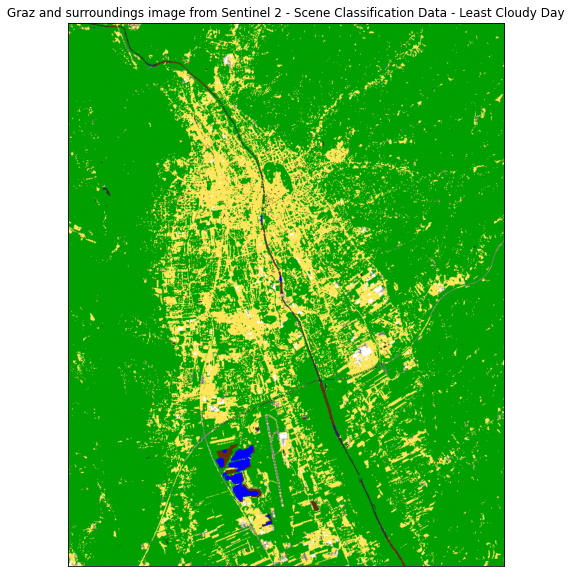

In [244]:
scl_image = request_SCL.get_data()
image_SCL = scl_image[0]
plot_image(image_SCL,factor=1/255, clip_range=(0,1))
plt.title('Graz and surroundings image from Sentinel 2 - Scene Classification Data - Least Cloudy Day')
print()

### d. Bonus  (find your algorithm to classify pixels in three classes: vegetation, non vegetation and water)

The indexes *NDWI* and *NDVI* are going to be used in my algorithm.

The values decided for my algorithm are:

- **NDWI > 0.2 : Water**
- **NDVI > 0.2 : Vegetation (returning NDVI in the green channel)**
- **Rest of values: Non vegetation**

In [246]:
evalscript_SCL_EO = """
//VERSION=3

function setup() {
        return {
            input: [{
                bands: ["B03", "B04", "B08"]
            }],
            output: {
                bands: 3
            }
        };
    }


function evaluatePixel(sample) {
    var NDWI=index(sample.B03,sample.B08); 
    var NDVI=index(sample.B08, sample.B04);

        if (NDWI > 0.2) {
            return [0, 0.5, 1]
            }
            
        if (NDVI>0.2){
            return [0, 0.3*NDVI, 0]
            }
        else {
            return [1, 0.902, 0]
            }
    }

"""
request_SCL_EO = SentinelHubRequest(
    evalscript=evalscript_SCL_EO,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=('2019-06-01', '2019-06-30'),
            mosaicking_order='leastCC'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=graz_bbox_SCL,
    size=graz_size_SCL,
    config=config
)

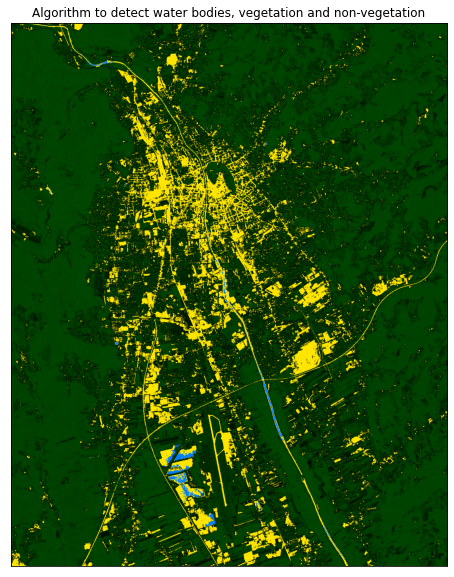

In [248]:
data_bonus = request_SCL_EO.get_data()
image_bonus = data_bonus[0]
plot_image(image_bonus,factor=1/255, clip_range=(0,1))
plt.title('Algorithm to detect water bodies, vegetation and non-vegetation')
print()

**Visual differences between my algorithm and SCL:**
1. In my algorithm, the water bodies at the below are smaller than in the SCL because of the accuracy of the SCL that divides between more categories so the result is of a higher quality.
2. The SCL algorithm does not show the image as sharp as my algorithm. This could be because of the accuracy of categories (there are 11 categories vs 3)
3. The result of the NDVI in the green channel of my algorithm improves the pureness of the image and the possibility to distinguish between the different values